In [1]:
import pandas as pd
import numpy as np

In [2]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
targets = pd.read_csv('target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)

In [3]:
data.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
0,0,60.000000,5,9,0,0,39,34,18,10,...,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,...,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,...,91,11,92,7,95,12,90,1,0,0.0
3,0,70.000000,1,4,2,0,23,14,31,3,...,87,11,94,11,95,12,87,2,0,0.0
4,0,78.000000,3,2,60,1,28,9,53,26,...,93,10,96,1,96,1,79,3,0,0.0


In [4]:
categorical.dtypes

STATE           object
CLUSTER          int64
HOMEOWNR        object
GENDER          object
DATASRCE         int64
RFA_2R          object
RFA_2A          object
GEOCODE2        object
DOMAIN_A        object
DOMAIN_B         int64
ODATEW_YR        int64
ODATEW_MM        int64
DOB_YR           int64
DOB_MM           int64
MINRDATE_YR      int64
MINRDATE_MM      int64
MAXRDATE_YR      int64
MAXRDATE_MM      int64
LASTDATE_YR      int64
LASTDATE_MM      int64
FIRSTDATE_YR     int64
FIRSTDATE_MM     int64
dtype: object

In [5]:
y = data['TARGET_B']
X = data.drop(columns=['TARGET_B','TARGET_D'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Split into numerical and categorical

#### Numerical

In [7]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

# Reset index to concat with categorical after encoding

X_train_num = X_train_num.reset_index(drop=True)
X_test_num = X_test_num.reset_index(drop=True)

Not going to normalize the numericals as I want to see how the random forests handles the data.

#### Categorical

In [8]:
X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

#### OneHot Encode the categorical columns

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
X_train_encode = encoder.transform(X_train_cat).toarray()
X_train_encode = pd.DataFrame(X_train_encode, columns=encoder.get_feature_names_out())
# we encode the test also but don't fit the encoder again
X_test_encode = encoder.transform(X_test_cat).toarray()
X_test_encode = pd.DataFrame(X_test_encode, columns=encoder.get_feature_names_out())

#### Concat the numerical and encoded categoricals

In [10]:
X_train_treated = pd.concat([X_train_num, X_train_encode], axis = 1)
X_test_treated  = pd.concat([X_test_num,  X_test_encode],  axis = 1)

In [11]:
print(X_train_treated.isna().sum().sum())
print(X_test_treated.isna().sum().sum())

0
0


#### Oversampling the Train data

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled_oversample, y_resampled_oversample = ros.fit_resample(X_train_treated, y_train)

In [13]:
X_resampled = pd.DataFrame(X_resampled_oversample, columns=X_resampled_oversample.columns)

In [14]:
X_resampled.head()


,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0,74.0,2,5,36,0,40,48,15,4,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,57.0,5,2,21,0,20,28,9,2,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0,46.0,4,9,0,0,31,15,36,7,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2,53.0,3,5,1,0,23,34,20,6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,71.0,5,9,0,0,32,18,46,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Rename for ease of use

X_train = X_resampled
X_test = X_test_treated
y_train = y_resampled_oversample

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6272525319424898
0.6133731593564953


### Trying KBest to reduce the features

In [17]:
%%time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


kbest = SelectKBest(chi2, k=10)
selector = kbest.fit(X_train, y_train)

X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

CPU times: user 1.02 s, sys: 809 ms, total: 1.83 s
Wall time: 2.04 s


In [19]:
df = pd.DataFrame(data = selector.scores_, columns = ['score'])
df['Column'] = X_train.columns
print(df.sort_values(by = ['score'], ascending = False).head(10))

            score    Column
311  3.597322e+06  CONTROLN
140  1.175955e+06       IC5
0    4.534439e+05     TCODE
83   3.540884e+05       HV1
84   3.456910e+05       HV2
13   2.558862e+05    POP901
133  1.555515e+05       MSA
14   4.814382e+04    POP902
15   3.456445e+04    POP903
303  2.781870e+04  RAMNTALL


In [21]:
cols = df.sort_values(by = ['score'], ascending = False).head(10)['Column']
cols

311    CONTROLN
140         IC5
0         TCODE
83          HV1
84          HV2
13       POP901
133         MSA
14       POP902
15       POP903
303    RAMNTALL
Name: Column, dtype: object

In [23]:
selected = pd.DataFrame(X_train_new)
selected.head()
selected.columns = cols
selected.head()

Column,CONTROLN,IC5,TCODE,HV1,HV2,POP901,MSA,POP902,POP903,RAMNTALL
0,0.0,1252.0,345.0,448.0,391.0,411.0,3760.0,10004.0,35.0,102393.0
1,0.0,865.0,236.0,316.0,316.0,378.0,8640.0,8416.0,36.0,118115.0
2,0.0,1412.0,399.0,485.0,812.0,878.0,0.0,15690.0,35.0,61111.0
3,2.0,11319.0,3240.0,4109.0,793.0,987.0,0.0,14133.0,109.0,28966.0
4,0.0,2961.0,823.0,1423.0,1487.0,1523.0,2160.0,24099.0,270.0,69126.0


In [26]:
clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train_new, y_train)
print(clf.score(X_train_new, y_train))
print(clf.score(X_test_new, y_test))

0.5713980185997737
0.5699313525127077


On first Glance it looks like the reduction of features decreased the quality of the model.
- But the parameters of the random forest needs to be optimized after the reduction of features

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_new)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    18095
1      988
Name: TARGET_B, dtype: int64

array([[10385,  7710],
       [  497,   491]])

In [34]:
cost_FP = 7710*.68
cost_FN = 497*15

print(f'cost of sending mail to non donors is {cost_FP}')
print(f'cost of missing donors is {cost_FN}')

cost of sending mail to non donors is 5242.8
cost of missing donors is 7455


In this case the cost of missing donors is higher than sending mails to non donors
- We could optimize the recall to decrease the number of missed donors
- Also since the difference in value is not big between both we could optimize the F1 score to optimize both of them

### Use Random grid to optimize the parameters for random forest

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


max_depth_choices= [3,4,5,6,7,8,9,10,None]
min_samples_split_choices = [2,3,4,5,6,7,8,9,10]
min_samples_leaf_choices = [2,3,4,5,6,7,8,9,10]
max_samples_choices = [1, 0.9, 0.8, 0.7, 0.6]


random_grid = {'max_depth': max_depth_choices,
               'min_samples_split': min_samples_split_choices,
               'min_samples_leaf': min_samples_leaf_choices,
               'max_samples': max_samples_choices}

Random grid took forever I stopped it

%%time

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator = model, param_grid = random_grid, cv = 5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_new, y_train)

### Optimize only the max_depth

In [38]:
max_depth = range(1,20)
test = []
train = []

for depth in max_depth:
    model = RandomForestClassifier(max_depth=depth, random_state=0)
    model.fit(X_train_new, y_train)
    test.append(model.score(X_test_new,y_test))
    train.append(model.score(X_train_new,y_train))

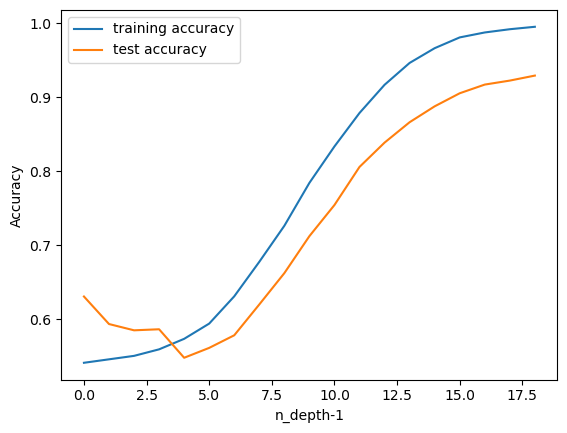

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()

Try 3 and 10 max depth

### Check the f1 score and try to optimize it

In [ ]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=10,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8
                            )
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

In [ ]:
cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')

In [ ]:
np.mean([0.59070713, 0.59693593, 0.59355595, 0.58903872, 0.5895198 ])